# ML MT2016 Project: Cats vs Dogs

## FINISH THIS
We attempt to train neural networks to distinguish between cats and dogs from the corresponding [open dataset](https://www.kaggle.com/c/dogs-vs-cats) on Kaggle.

The TensorFlow tutorials, howtos and example code (particularly that on [reading data](https://www.tensorflow.org/how_tos/reading_data/)), were used as guidance on code design and data/input handling.

## The Data
The input data consists of 25000 labelled images of cats and dogs (half of each). We also have an additional 12500 unlabelled images for classification and submission to Kaggle's public leaderboard. The images are of variable size, so all have been rescaled to 299 pixels in width and height. This transformation was done without regard for aspect ratio under the assumption that it's hard to stretch cats into dogs or vice versa. We chose 299 so we can easily feed the images into Inception. Finally the labelled data was split into train, validation and test sets and saved into TensorFlow `.tfrecord` files.

The labels are encoded as:

| label | encoding |
|-------|----------|
| cat | 0 |
| dog | 1 |

## The Models
### Fully Connected Network
 We first use a basic multilayer perceptron as a proof of concept. d will not spend a lot of time optimizing the hyperparameters or network structure since we do not expect the network architecture architecture to be well suited to computer vision anyway. Indeed, once trained, we only achieve about 60% test accuracy with this model.

### Convolutional Network
Next, we add some convolution layers, which are more suited to image recognition. See `DogsVsCats_Conv.ipynb`.

### Transfer Learning
Finally, we achieve ~X% using transfer learning. While we do not have sufficient computing power or problem specific training data to train a deep convolutional network, we can retrain the final layer of an existing network, such as Google's [Inception](https://github.com/tensorflow/models/tree/master/inception) network trained on [ImageNet](http://image-net.org). For more details see `DogsVsCats_Inception.ipynb`.

## Notes
### Overfitting
While minimizing the cross entropy on the training batches, we periodically compute the accuracy on the validation set. If we observe the validation error increasing while the training cross entropy is still falling, we are probably overfitting. We do not plot any learning graphs in this notebook, but the cross entropy and validation error are recorded with a TensorFlow `SummarySaver`, so plots can be viewed with TensorBoard.

### Initialization
Since we use relu nonlinearities, we use a modified version of Xavier initialization with initial weights for a node drawn from a normal distribution of variance $2/n$ where $n$ is the number of inputs of the node.
All biases are initialized to $1$.

In [1]:
from glob import glob
from math import ceil, sqrt
import os

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf

import dataset
import tfutil as tfu

## A Look at the Data
To check the data was read correctly, we display a random sample of training images.

In [2]:
tf.reset_default_graph()

with tf.Session() as sess:
    images, labels = dataset.inputs(name='train', batch_size=16, display=True)
    
    tf.global_variables_initializer().run()
    tf.local_variables_initializer().run()
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    sample_images, sample_labels = sess.run([images, labels])
    sample_labels = sample_labels.reshape([16])
    
    coord.request_stop()
    coord.join(threads)

/usr/lib64/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


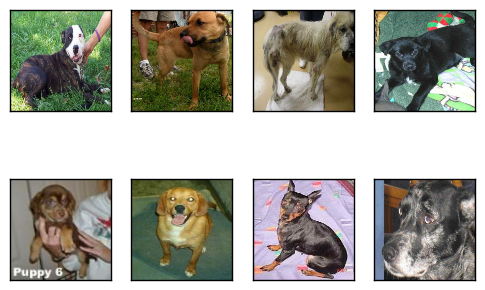

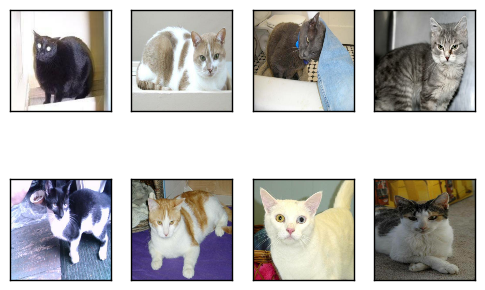

In [3]:
sample_cats = sample_images[sample_labels == 1]
sample_dogs = sample_images[sample_labels == 0]

cat_figure = plt.figure()
for i in range(len(sample_cats)):
    sub = cat_figure.add_subplot(ceil(len(sample_cats)/4), 4, i+1)
    
    # disable axes markings
    sub.set_xticks(())
    sub.set_yticks(())
    
    sub.imshow(sample_cats[i].reshape(dataset.image_dim(include_channels=True)))
cat_figure.show()

dog_figure = plt.figure()
for i in range(len(sample_dogs)):
    sub = dog_figure.add_subplot(ceil(len(sample_dogs)/4), 4, i+1)
    
    # disable axes markings
    sub.set_xticks(())
    sub.set_yticks(())
    
    sub.imshow(sample_dogs[i].reshape(dataset.image_dim(include_channels=True)))
dog_figure.show()

### Predict All Dogs
To provide a baseline for comparison (and to check the composition of our data is ok following the train/validation/test split), we check the performance of a predictor which labels every image as a dog. (And indeed this predictor gets about 50% as we might expect.)

In [4]:
def all_dog_inference_op(images):
    return tf.Variable(trainable=False, dtype=tf.float32, initial_value=tf.ones(shape=[images.shape[1]], dtype=tf.float32))

tf.reset_default_graph()

valid_images, valid_labels = dataset.inputs(name='validation', num_epochs=None)
valid_logits = all_dog_inference_op(valid_images)
valid_accuracy_op = tfu.accuracy_op(valid_logits, valid_labels, name='validation')
    
test_images, test_labels = dataset.inputs(name='test', num_epochs=None)
test_logits = all_dog_inference_op(test_images)
test_accuracy_op = tfu.accuracy_op(test_logits, test_labels, name='test')

init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

sess.run(init_op)
    
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

try:
    valid_accuracy = tfu.avg_op(sess, valid_accuracy_op)
    print('Validation accuracy: {acc:.1%}'.format(acc=valid_accuracy))
    test_accuracy = tfu.avg_op(sess, test_accuracy_op)
    print('Test accuracy: {acc:.1%}'.format(acc=test_accuracy))
except tf.errors.OutOfRangeError:
    pass
finally:
    coord.request_stop()
    
coord.join(threads)
sess.close()

Validation accuracy: 48.2%
Test accuracy: 48.7%


## Fully Connected

Now we build our first model, a fully connected feed forward network. We manage to obtain 66% accuracy on the test set with 3 hidden layers of respective sizes 128, 32 and 16. We do not spend much time trying to optimize this since we expect better performance with a convolutional network.

The first function builds the inference part of the graph and returns the computed logit (the likelihood the image is a dog). The second sets up the input queues and the evalution nodes of the graph. Finally, the calls to `run_training` and `run_prediction` create sessions, initialize variables, start threads and run training and prediction respectively (see `tfutil.py` for details).

In [5]:
# setting Train=False enables variable_scope reuse
# this means that when doing inference after training, the trained variables are not overwritten
def fc_inference_op(images, *hidden_layer_sizes, train=True):
    hidden_layer_count = 0
    last_layer_size = dataset.image_len()
    
    with tf.variable_scope('fc', reuse=(not train)):
        h = images

        for layer_size in hidden_layer_sizes:
            hidden_layer_count += 1
            node_name = 'layer{}'.format(hidden_layer_count)
            h = tfu.fc_op(h, last_layer_size, layer_size, name=node_name)
            last_layer_size = layer_size
            
        logits = tfu.fc_op(h, last_layer_size, 1, name='out', relu=False)
    
    return logits

def do_fc(*hidden_layer_sizes, total_epochs, learning_rate, name=''):
    def inference_op(images, train):
        return fc_inference_op(images, *hidden_layer_sizes, train=train)
    
    op_name = 'fc' + ('_' if name else '') + name
    
    tfu.run_all(
        inference_op=inference_op,
        inputs=dataset.inputs,
        total_epochs=total_epochs,
        learning_rate=learning_rate,
        name=op_name
    )

In [6]:
do_fc(128, 64, 32, 16, total_epochs=12, learning_rate=1e-4)

Validation accuracy: 48.5%
Cross Entropy: 0.7
Cross Entropy: 0.68
Cross Entropy: 0.69
Cross Entropy: 0.56
Validation accuracy: 68.2%
Cross Entropy: 0.52
Cross Entropy: 0.51
Cross Entropy: 0.56
Cross Entropy: 0.55
Validation accuracy: 66.7%
Cross Entropy: 0.48
Cross Entropy: 0.6
Cross Entropy: 0.45
Cross Entropy: 0.39
Validation accuracy: 68.0%
Cross Entropy: 0.37
Cross Entropy: 0.42
Cross Entropy: 0.29
Cross Entropy: 0.26
Validation accuracy: 66.6%
Cross Entropy: 0.14
Cross Entropy: 0.26
Cross Entropy: 0.13
Done training for 4733 steps.
Test accuracy: 65.4%
Wrote 12500 predictions to ./data/fc.txt


Got 17.26979 on the Kaggle data.

67.3% test accuracy, xentropy down to ~0.3

In [7]:
do_fc(256, 1024, 512, 128, 64, 32, 8, total_epochs=10, learning_rate=1e-4, name='big')

Validation accuracy: 48.4%
Cross Entropy: 0.76
Cross Entropy: 0.67
Cross Entropy: 0.7
Cross Entropy: 0.68
Validation accuracy: 64.4%
Cross Entropy: 0.54
Cross Entropy: 0.6
Cross Entropy: 0.57
Cross Entropy: 0.56
Validation accuracy: 65.2%
Cross Entropy: 0.58
Cross Entropy: 0.62
Cross Entropy: 0.57
Cross Entropy: 0.5
Validation accuracy: 66.4%
Cross Entropy: 0.48
Cross Entropy: 0.34
Cross Entropy: 0.45
Cross Entropy: 0.41
Done training for 3944 steps.
Test accuracy: 65.6%
Wrote 12500 predictions to ./data/fc_big.txt
